## Fitting custom models with sasmodels and bumps optimization

Resources to follow : 
1. https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/scripting.html
2. https://github.com/bumps/bumps

In [14]:
import numpy as np
import matplotlib.pyplot as plt

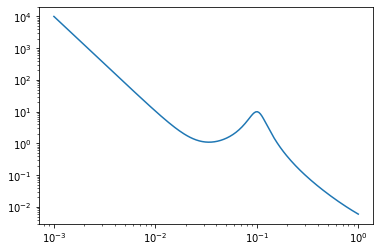

In [15]:
from sasmodels.core import load_model
from sasmodels.direct_model import call_kernel

model = load_model("./broad_peak.py")
q = np.logspace(-3, 0, 200)
kernel = model.make_kernel([q])
pars = {}
Iq = call_kernel(kernel, pars)
fig, ax = plt.subplots()
ax.loglog(q, Iq)
plt.show()

### Add polydispersity using sasmodels interface

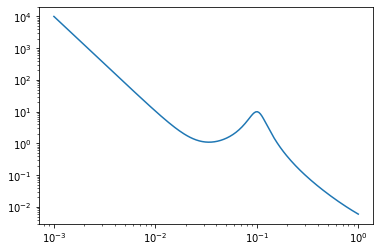

In [28]:
pars = {'porod_exp_pd':2.0, 'porod_exp_pd_n':10, 'porod_exp_pd_nsigma':1.0}
Iq = call_kernel(kernel, pars)
fig, ax = plt.subplots()
ax.loglog(q, Iq)
plt.show()

## Using the sasmodels kernel with bumps optimizers 🤦🏻‍♂️

In [16]:
from bumps.names import *
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import Data1D 

resolution = 0.5
dIq = resolution*Iq
dq = resolution*q
data = Data1D(q, Iq, dx=dq, dy=dIq)
model = Model(kernel)
model.porod_exp.range(2.0,5.0)
cutoff = 1e-3  # low precision cutoff
M = Experiment(data=data, model=model, cutoff=cutoff)
problem = FitProblem(M)

## Using the sasmodels kernel with lmfit 😍

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 216
    # data points      = 200
    # variables        = 7
    chi-square         = 21171963.8
    reduced chi-square = 109699.294
    Akaike info crit   = 2327.97421
    Bayesian info crit = 2351.06243
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    porod_scale:         0.00813438 (init = 1e-05), model_value = 1e-05
    porod_exp:           2.00000000 (init = 2), model_value = 3
    peak_scale:          10.0000000 (init = 10), model_value = 5
    correlation_length:  50.0000000 (init = 50), model_value = 20
    peak_pos:            0.10000000 (init = 0.1), model_value = 0.1
    width_exp:           2.00000000 (init = 2), model_value = 1
    shape_exp:           1.

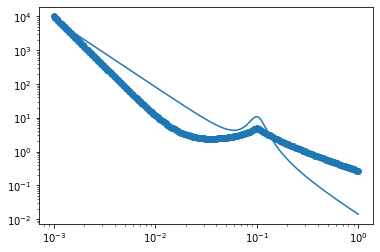

In [23]:
from lmfit import create_params, minimize
from lmfit.printfuncs import report_fit

p_true = create_params(porod_scale=1.0e-5,
       porod_exp=3.0,
       peak_scale=5.0,
       correlation_length=20.0,
       peak_pos=0.1,
       width_exp=1.0,
       shape_exp=1.0)

def residual(pars, data=None):
    Iq = call_kernel(kernel, pars)
    if data is None:
        return Iq
    
    return Iq - data


fit_params = create_params(porod_scale=dict(value=1.0e-5, max=1e8, min=1e-8),
       porod_exp=dict(value=2.0, max=10.0, min=-10.0),
       peak_scale=dict(value=10.0, max=100.0, min=0.0),
       correlation_length=dict(value=50.0, max=100.0, min=0.0),
       peak_pos=dict(value=0.1, max=1.0, min=0.0),
       width_exp=dict(value=2.0, max=10.0, min=0.0),
       shape_exp=dict(value=1.0, max=10.0, min=0.0)
       )

Iq_true = residual(p_true)

out = minimize(residual, fit_params, kws={'data': Iq_true}, method='lbfgsb')
fit = residual(out.params)
report_fit(out, modelpars=p_true)
fig, ax = plt.subplots()
ax.plot(q, fit, label='Model fit')
ax.scatter(q, Iq_true, label='Data')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()